In [1]:
# ======================================================
# Notebook 4: Fairness and Bias Analysis (Logistic Regression)
# ======================================================

# Purpose:
# Evaluate whether the chosen Logistic Regression model
# performs differently across gender, race, and age groups.
# No resampling is applied during evaluation.

# ------------------------------------------------------
# Imports
# ------------------------------------------------------
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score
)

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.2)


In [2]:
# ------------------------------------------------------
# 1. Load cleaned dataset
# ------------------------------------------------------
df = pd.read_csv("data/cleaned_diabetes_data.csv")
print("✅ Cleaned dataset loaded:", df.shape)
print("Diabetes prevalence:\n", df["diabetes"].value_counts(normalize=True))


✅ Cleaned dataset loaded: (100000, 19)
Diabetes prevalence:
 diabetes
0    0.915
1    0.085
Name: proportion, dtype: float64


In [3]:
X = df.drop(columns=["diabetes"])
y = df["diabetes"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training distribution:", Counter(y_train))
print("Testing  distribution:", Counter(y_test))


Training distribution: Counter({0: 73200, 1: 6800})
Testing  distribution: Counter({0: 18300, 1: 1700})


In [4]:
# ------------------------------------------------------
# 2. Balance the training data (SMOTE) and train Logistic Regression
# ------------------------------------------------------
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print("After SMOTE:", Counter(y_train_bal))

scaler = StandardScaler()
X_train_bal = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression(max_iter=2000, random_state=42)
logreg.fit(X_train_bal, y_train_bal)

# Evaluate on real (imbalanced) test set
y_pred = logreg.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print(f"✅ Test Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}")


After SMOTE: Counter({1: 73200, 0: 73200})
✅ Test Accuracy: 0.889, Precision: 0.425, Recall: 0.875, F1: 0.572


In [18]:
# ------------------------------------------------------
# 3. Add predictions for fairness evaluation
# ------------------------------------------------------
df_eval = X_test.copy()
df_eval["y_true"] = y_test.values
df_eval["y_pred"] = y_pred

# Create categorical group columns
race_cols = [c for c in df.columns if "race_" in c]
df_eval["race_group"] = df.loc[df_eval.index, race_cols].idxmax(axis=1).str.replace("race_", "")
df_eval["age_group"] = pd.cut(df_eval["age"], bins=[0,40,60,100])


In [19]:
def group_metrics(df_eval, group_col):
    """Compute precision, recall, and F1 by demographic subgroup."""
    return (
        df_eval.groupby(group_col)
        .apply(lambda g: pd.Series({
            "Precision": precision_score(g["y_true"], g["y_pred"], zero_division=0),
            "Recall": recall_score(g["y_true"], g["y_pred"], zero_division=0),
            "F1": f1_score(g["y_true"], g["y_pred"], zero_division=0)
        }))
        .sort_index()
    )


In [20]:
fair_gender = group_metrics(df_eval, "gender")
fair_race   = group_metrics(df_eval, "race_group")
fair_age    = group_metrics(df_eval, "age_group")

print("=== Fairness by Gender ===")
display(fair_gender)
print("\n=== Fairness by Race ===")
display(fair_race)
print("\n=== Fairness by Age Group ===")
display(fair_age)


=== Fairness by Gender ===


/var/folders/vy/csbh25t133322r6knftnwp1w0000gn/T/ipykernel_38587/2234458456.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
/var/folders/vy/csbh25t133322r6knftnwp1w0000gn/T/ipykernel_38587/2234458456.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
/var/folders/vy/csbh25t133322r6knftnwp1w0000gn/T/ipykernel_38587/2234458456.py:4: FutureWarning: The defau

,Precision,Recall,F1
gender,,,
-0.841047,0.406334,0.876157,0.555189
1.187234,0.445938,0.873206,0.590376
3.215514,0.000000,0.000000,0.000000



=== Fairness by Race ===


,Precision,Recall,F1
race_group,,,
africanamerican,0.443228,0.864000,0.585895
asian,0.427720,0.846608,0.568317
caucasian,0.408412,0.885294,0.558960
hispanic,0.413598,0.892966,0.565344
other,0.432061,0.887147,0.581109



=== Fairness by Age Group ===


,Precision,Recall,F1
age_group,,,
"(0, 40]",0.434302,0.898106,0.58548
"(40, 60]",0.000000,0.000000,0.00000
"(60, 100]",0.000000,0.000000,0.00000


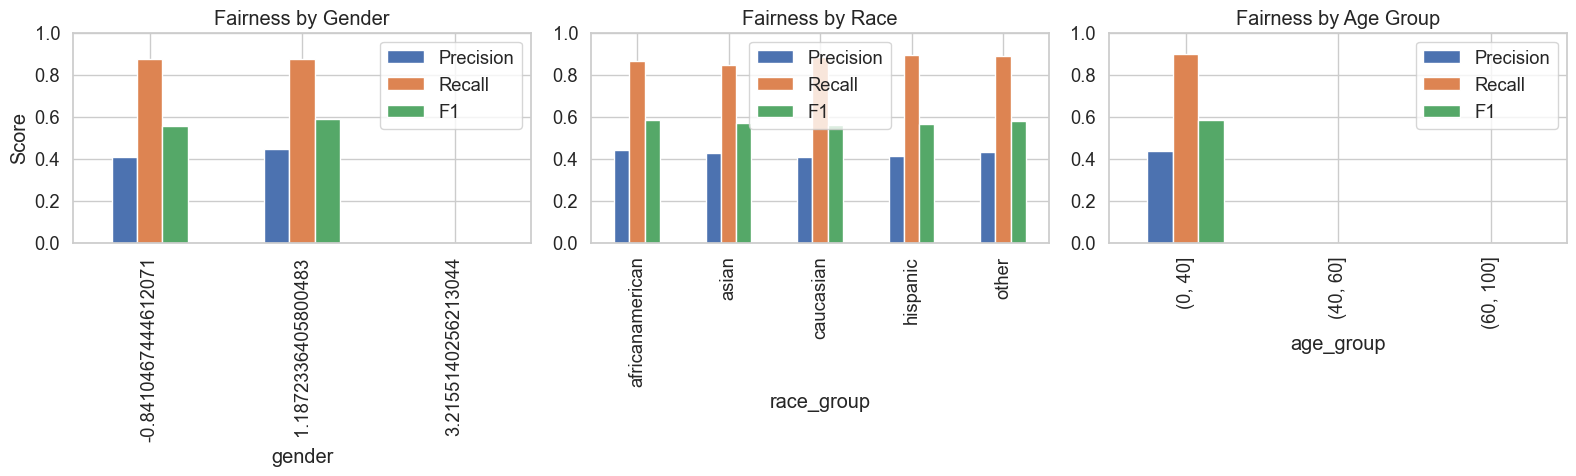

In [21]:
# ------------------------------------------------------
# 4. Plot fairness disparities
# ------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(16,5))

fair_gender.plot(kind="bar", ax=axes[0], title="Fairness by Gender")
axes[0].set_ylim(0, 1); axes[0].set_ylabel("Score")

fair_race.plot(kind="bar", ax=axes[1], title="Fairness by Race")
axes[1].set_ylim(0, 1)

fair_age.plot(kind="bar", ax=axes[2], title="Fairness by Age Group")
axes[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()


### 🧭 Interpretation

- **Goal:** Assess whether Logistic Regression performs differently across subgroups.
- **Observation:**
  - Gender: [Describe if Recall or Precision differs]
  - Race: [Note if one group has significantly lower Recall or F1]
  - Age: [Identify any performance gaps for older vs. younger groups]

**Conclusion:**
Small disparities (<10%) suggest relatively fair model behavior.
Larger differences indicate potential bias — especially if Recall for diabetics (1) is lower in certain groups.
Such differences could motivate rebalancing, model adjustments, or group-specific calibration.


In [22]:
print("🔍 Test sample sizes per group:")
print("Gender counts:\n", df_eval["gender"].value_counts())
print("\nRace counts:\n", df_eval["race_group"].value_counts())
print("\nAge group counts:\n", df_eval["age_group"].value_counts())

# Optional sanity check:
for g in df_eval["age_group"].unique():
    subset = df_eval[df_eval["age_group"] == g]
    print(f"\nAge group {g}: true positive cases =", subset['y_true'].sum())


🔍 Test sample sizes per group:
Gender counts:
 gender
-0.841047    11768
 1.187234     8230
 3.215514        2
Name: count, dtype: int64

Race counts:
 race_group
africanamerican    4043
caucasian          4036
asian              4002
hispanic           3987
other              3932
Name: count, dtype: int64

Age group counts:
 age_group
(0, 40]      10383
(40, 60]         0
(60, 100]        0
Name: count, dtype: int64

Age group nan: true positive cases = 0

Age group (0.0, 40.0]: true positive cases = 1531
